# Quantum Error Correction with Faulty Quantum Computers

Author: Chengyi Tang

Date: April 28, 2024

Course: PHYS064 - Mathematical and Computational Methods for Physicists

In this project, I will simulate errors in quantum computers and apply error correcting codes to correct these errors. I will also evaluate how effective error correcting codes are given the imperfect nature of quantum gates. For basics of quantum computing and error correction techniques, see my writeup here: {link}.

In [56]:
from collections import Counter
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

## Constructing Quantum Errors

### Single Qubit Errors

The most basic types of errors in quantum computing are bit-flip and phase-flip errors. Given a quantum state $\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$, the bit-flip error changes the state to $\ket{\psi} = \beta \ket{0} + \alpha \ket{1}$ and the phase-flip error changes the state to $\ket{\psi} = \alpha \ket{0} - \beta \ket{1}$. In the following code, we assume a 5% error rate:

In [2]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


We can also construct composite errors:

In [3]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


The four types of errors above form a complete basis for all the single-qubit errors that could occur.

Another type of error that could occurs is a readout error, where the recorded classical value differes from the actual measured value:

In [5]:
readout_error = ReadoutError([[0.9, 0.1], [0.25, 0.75]])
print(readout_error)

ReadoutError on 1 qubits. Assignment probabilities:
 P(j|0) =  [0.9 0.1]
 P(j|1) =  [0.25 0.75]


### Multiple Qubit Errors and Noise Models

The first way to construct multiple-qubit errors is by performing the tenwor product of two errors:

In [9]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


A more comprehensive way that combines composition and tensor products is a **noise model**, where we can specify the type of instruction it performs and which qubits it is applied to. We can perform errors on all qubits on specific qubits, which allows us to fine-tune our noise models.

We start with an all-qubit error with depolarizing errors. Depolarizing errors describes the decoherence of quantum information due to the interaction between a qubit and is environment.

In [26]:
# Create the Noise Model
noise_model_0 = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
d_error = depolarizing_error(0.05)
noise_model_0.add_all_qubit_quantum_error(d_error, ['u1', 'u2', 'u3'], [0])

print(noise_model_0)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


We can specify which qubit we want to apply the error to by using the `add_quantum_error` function and specifying which qubits have errors associated with them:

In [27]:
noise_model_1 = NoiseModel()

noise_model_1.add_quantum_error(d_error, ['u1', 'u2', 'u3'], [0])

print(noise_model_1)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'u3']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


Now we can test our noise models to see that they are actually outputting the errors we expect. To do this, we first construct a circuit:

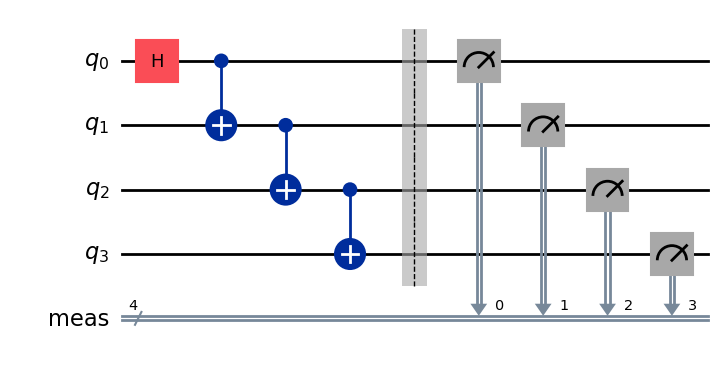

In [46]:
# create circuit object
qc_test = QuantumCircuit(4)

# add gates
qc_test.h(0)
for i in range(3):
    qc_test.cx(i, i+1)
qc_test.measure_all()

# visualize the circuit
qc_test.draw('mpl')

For reference, we first run an ideal simulation of the circuit. Theoretically, the above circuit should output an equal superposition of $\ket{0000}$ and $\ket{1111}$:

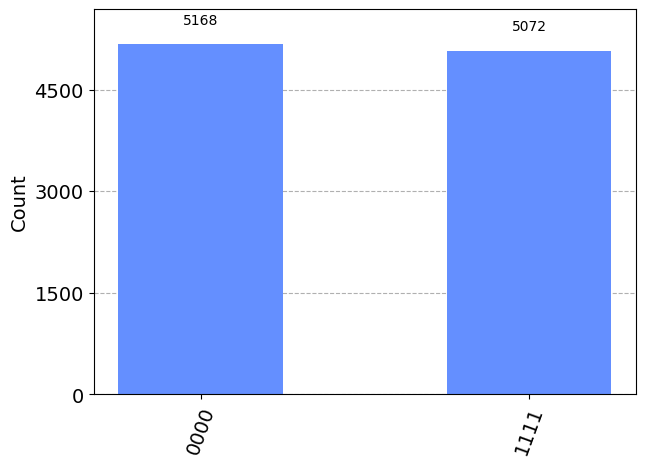

In [57]:
sim_ideal = AerSimulator()

# run the simulation 10 times since Aer only returns 1024 shots
counts_ideal = {}
for run in range(10):
    result_ideal = sim_ideal.run(qc_test).result()
    counts_ideal_temp = result_ideal.get_counts()
    counts_ideal = dict(Counter(counts_ideal) + Counter(counts_ideal_temp))
plot_histogram(counts_ideal)


They are similar in counts, as expected. Now we execute a noisy simulatioin with `noise_model_0`, which is the decoherence noise model:

## Applying Quantum Errors

## Error Correction Codes